# Лабораторная работа #1: Рекуррентные нейронные сети

## Задача 1: PoS-tagging

В данной лабораторной работе будут использоваться корпуса проекта Universal Dependencies: http://universaldependencies.org/

Ukranian - https://github.com/UniversalDependencies/UD_Ukrainian-IU/tree/master

УКРАИНСКИЙ ЯЗЫК 

Индоевропейская семья; Славянская ветвь

-Восточнославянская группа
Родственные языки: белорусский, русский

### Часть I Работа с корпусом CoNLL
Предварительная обработка, чтение и парсинг корпуса, а также определение размера словаря.
Необходимо получить следущие статистики:

* Число предложений / уникальных словоформ;
* Число уникальных PoS-тегов;
* Максимальное и минимальное число слов в предложении;
* Математическое ожидание и медиана числа слов в предложении;
* Доля новых (не встречавшихся в тренировочной выборке) слов в тестовой выборке

In [3]:
%matplotlib inline
from conllu import parse, parse_tree
from collections import Counter
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, RepeatVector, Embedding, GRU, LSTM, SimpleRNN, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import top_k_categorical_accuracy

from tensorflow.keras.preprocessing import sequence

from tensorflow.keras import utils

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

CUSTOM_SEED = 42
np.random.seed(CUSTOM_SEED)

**Имена файлов с тренировочным и тестовым наборами:**

In [4]:
train_conll_fname = 'uk_iu-ud-train.conllu'
test_conll_fname = 'uk_iu-ud-test.conllu'       

Функция 
    parsed_sentences
читает conll файл, и проводит его обработку, подсчитывая:
* sents_word - список списков словоформ (внешний список - предложения, внутренний список - слова в этом предложении);
* word_frequencies - коллекция типа Counter для подсчета частоты словоформ
* sents_pos - список списов PoS тегов (соответствующих словам из sents_word);
* pos_frequencies - коллекция типа Counter для подсчета частоты PoS-тегов.

In [5]:
def parsed_sentences(conll_fname):
    conll_file = open(conll_fname, 'r', encoding='utf-8')
    conll_data = conll_file.read()
    conll_file.close()
    
    sents_word = []
    word_frequencies = Counter()
    
    sents_pos = []
    pos_frequencies = Counter()

    for current_parsed_sentence in parse(conll_data):
        current_sentence_words = []
        current_sentence_pos = []        
        for separated_parsed_words in current_parsed_sentence:
            current_sentence_words.append(separated_parsed_words['form'])
            word_frequencies[separated_parsed_words['form']] += 1
            current_sentence_pos.append(separated_parsed_words['upostag'])
            pos_frequencies[separated_parsed_words['upostag']] += 1
        
        sents_word.append(current_sentence_words)
        sents_pos.append(current_sentence_pos)

    return (sents_word, word_frequencies,
           sents_pos, pos_frequencies)


Считываем файлы тренировочной и тестовой выборки, и формируем (для каждого свою) наборы 
* sents_word
* word_frequencies
* sents_pos
* pos_frequencies

In [6]:
sents_word, word_frequencies, sents_pos, pos_frequencies = parsed_sentences(train_conll_fname)
test_sents_word, test_word_frequencies, test_sents_pos, test_pos_frequencies = parsed_sentences(test_conll_fname)

Выведете статистику, для тренировочной и тестовой выборки
Статистика должна отражать:
* Число предложений;
* Число словоформ;
* Число уникальных PoS тегов;
* Максимальное число слов в предложении;
* Минимальное число слов в предложении;
* Среднее арифметическое и среднее медианное число слов в предложении;
* Доля уникальных слов в тестовой выборке;

In [7]:
print("Stats: ")

train_length_of_sentences_list = np.array([len(current_sentence) for current_sentence in sents_word])
test_length_of_sentences_list = np.array([len(current_sentence) for current_sentence in test_sents_word])

print("Train set: \n\tCount sentences: {} \n\tUnique words: {}".format(len(sents_word), len(word_frequencies)))
print("\tUnique PoS tags: {}".format(len(pos_frequencies)))
print("\tMax count words in sentences: {}".format(np.max(train_length_of_sentences_list)))
print("\tMin count words in sentence: {}".format(np.min(train_length_of_sentences_list)))
print("\tMiddle count words in sentence: {}".format(np.mean(train_length_of_sentences_list)))
print("\tMedian count words in sentence: {}".format(np.median(train_length_of_sentences_list)))
print("\tPercent of unique PoS tags in test: {}".format(100 - len(set(train_length_of_sentences_list)&set(test_length_of_sentences_list))/ 
len(set(train_length_of_sentences_list))*100))

Stats: 
Train set: 
	Count sentences: 5496 
	Unique words: 27410
	Unique PoS tags: 18
	Max count words in sentences: 197
	Min count words in sentence: 1
	Middle count words in sentence: 16.855349344978166
	Median count words in sentence: 14.0
	Percent of unique PoS tags in test: 25.80645161290323


На основании полученных статистик, задаем параметры для нейронных сетей:
* Максимальная длина последовательности (MAX_SEQLEN);
* Максимальное количество атрибутов (S_MAX_FEATURES);
* Максимальное количество тегов (T_MAX_FEATURES);

**Замечание**: *MAX_SEQLEN* не обязательно должна равна максимальному числу слов в предложении, особенно если встречается всего 1 такое предложение.

In [8]:
MAX_SEQLEN = 17
S_MAX_FEATURES = 27410
T_MAX_FEATURES = 18

Объясните свой выбор целевых параметров:
* MAX_SEQLEN - выбрано среднее значение числа слов в предложении  
* S_MAX_FEATURES - выбрано количество уникальных слов во всем тексте, для максмального
* T_MAX_FEATURES 

Задаем параметры для числа нейронов в скрытом слое, объема пространства погружения и размера пакета.

In [9]:
EMBED_SIZE = 300
HIDDEN_SIZE = 100

BATCH_SIZE = 64

Задаем число эпох и итераций:

In [10]:
NUM_EPOCHS = 5
NUM_ITERATIONS = 6

Как и в большинстве других задач глубокого обучения, каждая строчка должна быть закодирована индексами слов. Кроме того, выход (PoS-теги) должны быть последовательностями индексов PoS-тегов.
Поэтомк, мы создаем табличцы для перевода слов/PoS-тегов в соответствующие индексы.
Словарь словоформ должен иметь 2 дополнительных метки:
* PAD - для заполнения (характеризует пустоту), когда размер предложения меньше, чем MAX_SEQLEN
* UNK - для неизвестных словоформ.

Кроме того, захотим проиллюстрировать PoS-теггер, поэтому нужно составить таблицы для поиска словоформ и частеречевых тегов.
Ниже показано задание таблиц.

Составляем таблицу поиска для словоформ:

In [11]:
s_vocabsize = min(len(word_frequencies), S_MAX_FEATURES) + 2
s_word2index = {x[0]:i+2 for i, x in 
    enumerate(word_frequencies.most_common(S_MAX_FEATURES))}
s_word2index["PAD"] = 0 # Для заполнения, когда размер предлложения меньше, чем MAX_SEQ
s_word2index["UNK"] = 1 # Для неизвестных словоформ, которые могут встретиться
s_index2word = {v:k for k, v in s_word2index.items()}

**Замечание: ** для PoS-тегов элемент UNK не нужен, поскольку список частей речи уже известен. Элемент PAD нужен.

In [12]:
t_vocabsize = min(len(pos_frequencies), T_MAX_FEATURES) + 1
t_word2index = {x[0]:i+1 for i, x in 
    enumerate(pos_frequencies.most_common(T_MAX_FEATURES))}

t_word2index["PAD"] = 0
t_index2word = {v:k for k, v in t_word2index.items()}

### Описание задания и работы используемых нейронных сетей

Составляем целевую нейронную сеть, которая и будет выполнять частеречную разметку.

Коротко об архитектуре нейронной сети:
Как и в других задачах, считаем, что входом в нейросеть является трехмерный тензор, элементами которого являются индексы слов, длины MAX_SEQLEN;

Это проходит через слой погружения (Embedding), которому явно указывается размер словаря и размерность погружения, поэтому результат прохождения входного тензора через слой погружения будет тензор сл. формата:
(None, MAX_SEQLEN, EMBED_SIZE);

Далее этот тензор передается encoder'у - представляющий собой слой рекуррентной нейронной сети с размером выхода HIDDEN_SIZE. LSTM настроен на возврат единственного контекстного вектора (return_sequences=False - по умолчанию) после обработки последовательности длины MAX_SEQLEN, поэтому тензор LSTM слоя имеет форму (None, HIDDEN_SIZE).

Этот контекстный вектор далее реплицируется слоем 
    RepeatVector
в тензор формы (None, MAX_SEQLEN, t_vocab_size). В качестве функции активации в плотном слое используется softmax.


**Рассмотрим 4 архитектуры для нейронных сетей**:
* LSTM
* Bidirectional LSTM
* GRU
* SimpleRNN

*Дополнительная функция для визуализации результатов:*

In [13]:
def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """
    blue= '#34495E'
    green = '#2ECC71'
    orange = '#E23B13'
    # plot model loss
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))
    ax1.plot(range(1, len(train_loss) + 1), train_loss, blue, linewidth=3, label='training')
    ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, green, linewidth=3, label='validation')
    ax1.set_ylabel('loss')
    ax1.tick_params('y')
    ax1.legend(loc='upper right', shadow=False)
    ax1.set_title('Model loss through #epochs', color=orange, fontweight='bold')
    # plot model accuracy
    ax2.plot(range(1, len(train_acc) + 1), train_acc, blue, linewidth=3, label='training')
    ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, green, linewidth=3, label='validation')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel('accuracy')
    ax2.tick_params('y')
    ax2.legend(loc='lower right', shadow=False)
    ax2.set_title('Model accuracy through #epochs', color=orange, fontweight='bold')

В качестве потерь мы используем категориальную энтропию, т.к. решаем задачу Multi-Class Classification
    

### LSTM Architecture

In [14]:
def build_pos_tagger_LSTM():
    model = Sequential()
    model.add(Embedding(s_vocabsize, EMBED_SIZE,
                    input_length=MAX_SEQLEN,
                    embeddings_initializer="glorot_uniform"))
    
    model.add(LSTM(HIDDEN_SIZE))
    model.add(RepeatVector(MAX_SEQLEN))
    
    model.add(LSTM(HIDDEN_SIZE, return_sequences=True))
    model.add(TimeDistributed(Dense(t_vocabsize)))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
    return model

LSTM_POS_TAGGER = build_pos_tagger_LSTM()
LSTM_POS_TAGGER.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 17, 300)           8223600   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 17, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 17, 100)           80400     
_________________________________________________________________
time_distributed (TimeDistri (None, 17, 19)            1919      
_________________________________________________________________
activation (Activation)      (None, 17, 19)            0         
Total params: 8,466,319
Trainable params: 8,466,319
Non-trainable params: 0
_________________________________________________________________


### Biderectional LSTM Architecture

In [15]:
def build_pos_tagger_Bidirectional():
    model = Sequential()
    model.add(Embedding(s_vocabsize, EMBED_SIZE,
                    input_length=MAX_SEQLEN,
                    embeddings_initializer="glorot_uniform"))
    
    model.add(Bidirectional(LSTM(HIDDEN_SIZE))) 
    model.add(RepeatVector(MAX_SEQLEN)) 
    model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True))) 
    model.add(TimeDistributed(Dense(t_vocabsize))) 
    model.add(Activation("softmax")) 
    model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
    return model

Bidirectional_POS_TAGGER = build_pos_tagger_Bidirectional()
Bidirectional_POS_TAGGER.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 17, 300)           8223600   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               320800    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 17, 200)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 17, 200)           240800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 17, 19)            3819      
_________________________________________________________________
activation_1 (Activation)    (None, 17, 19)            0         
Total params: 8,789,019
Trainable params: 8,789,019
Non-trainable params: 0
_________________________________________________________________


### GRU Architecture

In [16]:
def build_pos_tagger_GRU():
    model = Sequential()
    model.add(Embedding(s_vocabsize, EMBED_SIZE,
                    input_length=MAX_SEQLEN,
                    embeddings_initializer="glorot_uniform"))
    
    model.add(GRU(HIDDEN_SIZE))
    model.add(RepeatVector(MAX_SEQLEN))
    
    model.add(GRU(HIDDEN_SIZE, return_sequences=True))
    model.add(TimeDistributed(Dense(t_vocabsize)))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
    return model

GRU_POS_TAGGER = build_pos_tagger_GRU()
GRU_POS_TAGGER.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 17, 300)           8223600   
_________________________________________________________________
gru (GRU)                    (None, 100)               120300    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 17, 100)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 17, 100)           60300     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 17, 19)            1919      
_________________________________________________________________
activation_2 (Activation)    (None, 17, 19)            0         
Total params: 8,406,119
Trainable params: 8,406,119
Non-trainable params: 0
_________________________________________________________________


### SimpleRNN Architecture

In [17]:
def build_pos_tagger_SimpleRNN():
    model = Sequential()
    model.add(Embedding(s_vocabsize, EMBED_SIZE,
                    input_length=MAX_SEQLEN,
                    embeddings_initializer="glorot_uniform"))
    
    model.add(SimpleRNN(HIDDEN_SIZE))
    model.add(RepeatVector(MAX_SEQLEN))
    
    model.add(SimpleRNN(HIDDEN_SIZE, return_sequences=True))
    model.add(TimeDistributed(Dense(t_vocabsize)))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
    return model

SimpleRNN_POS_TAGGER = build_pos_tagger_SimpleRNN()
SimpleRNN_POS_TAGGER.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 17, 300)           8223600   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               40100     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 17, 100)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 17, 100)           20100     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 17, 19)            1919      
_________________________________________________________________
activation_3 (Activation)    (None, 17, 19)            0         
Total params: 8,285,719
Trainable params: 8,285,719
Non-trainable params: 0
_________________________________________________________________


## Обучаем модели и посчитываем статистики

Подсчитаем объем количества батчей для тренировочной и тестовой выборки, кроме того, сделаем функцию для получения генератора батчей.

In [18]:
num_train_samples = len(sents_word) // BATCH_SIZE
num_test_samples = len(test_sents_word) // BATCH_SIZE

print("\tV of train samples: {}".format(num_train_samples))
print("\tV of test samples: {}".format(num_test_samples))

def get_or_else(dictionary, key, default_value):
    try:
        return dictionary[key]
    except KeyError:
        return default_value

def generate_batch(
    s_sents,  # sentences_train
    s_word2index, # word to index dictionary
    t_sents, # 
    t_word2index, 
    batch_size, 
    maxlen
):
    while True:
        # shuffle the input
        indices = np.random.permutation(np.arange(len(s_sents)))
        ss_sents = [s_sents[ix] for ix in indices]
        ts_sents = [t_sents[ix] for ix in indices]
        # convert to word indices
        si_sents = [[get_or_else(s_word2index, word, s_word2index["UNK"]) 
                    for word in sent] 
                    for sent in ss_sents]
        ti_sents = [[t_word2index[word] for word in sent]
                    for sent in ts_sents]
        # inner loop should run for an epoch
        num_batches = len(s_sents) // batch_size
        for i in range(num_batches):
            s_batch = si_sents[i * batch_size : (i + 1) * batch_size]
            t_batch = ti_sents[i * batch_size : (i + 1) * batch_size]
            sp_batch = sequence.pad_sequences(s_batch, maxlen=maxlen)
            tp_batch = sequence.pad_sequences(t_batch, maxlen=maxlen)
            tpc_batch = utils.to_categorical(tp_batch.reshape(-1, 1), 
                num_classes=len(t_word2index)).reshape(batch_size, 
                -1, len(t_word2index))
            yield sp_batch, tpc_batch

	V of train samples: 85
	V of test samples: 13


## 1. LSTM

Инициализируем генераторы для тренировочной и тестовой выборки. 

In [33]:
train_gen = generate_batch(sents_word, s_word2index, sents_pos,
                           t_word2index, BATCH_SIZE, MAX_SEQLEN)
test_gen = generate_batch(test_sents_word, s_word2index, test_sents_pos,
                          t_word2index, BATCH_SIZE, MAX_SEQLEN)

Обновляем списки с историями для точности, функции потерь на тренировочной и тестовой выборках:

In [34]:
hist_acc, hist_val_acc, hist_loss, hist_val_loss = [], [], [], []


In [35]:
for i in range(NUM_ITERATIONS):    
    history = LSTM_POS_TAGGER.fit_generator(train_gen, 
                                  steps_per_epoch=num_train_samples, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=test_gen, 
                                  validation_steps=num_test_samples)
    # save off history data
    hist_acc.extend(history.history["acc"])
    hist_val_acc.extend(history.history["val_acc"])
    hist_loss.extend(history.history["loss"])
    hist_val_loss.extend(history.history["val_loss"])
    
    # Проиллюстрируем некоторые примеры разметки
    
    Xtest, Ytest = next(test_gen)
    Ytest_ = LSTM_POS_TAGGER.predict(Xtest)
    ytest = np.argmax(Ytest, axis=2)
    ytest_ = np.argmax(Ytest_, axis=2)
    
    print("=" * 80)
    print("Iteration # {:d}".format(i + 1))
    print("-" * 80)
    for i in range(min(5, Ytest.shape[0])):
        sent_ids = Xtest[i]
        sent_words = [s_index2word[x] for x in sent_ids.tolist()]
        pos_labels = [t_index2word[x] for x in ytest[i].tolist()]
        pos_preds = [t_index2word[x] for x in ytest_[i].tolist()]
        triples = [x for x in zip(sent_words, pos_labels, pos_preds)
            if x[0] != "PAD"]
        print("label:     " + " ".join([x[0] +"//"+x[1].upper() 
            for x in triples]))
        print("predicted: " + " ".join([x[0] +"//"+x[2].upper() 
            for x in triples]))
        print("-" * 80)

Epoch 1/5
85/85 [==============================] - 13s 156ms/step - loss: 0.7579 - acc: 0.7138 - val_loss: 1.6254 - val_acc: 0.5259
Epoch 2/5
85/85 [==============================] - 13s 157ms/step - loss: 0.7265 - acc: 0.7249 - val_loss: 1.6316 - val_acc: 0.5286
Epoch 3/5
85/85 [==============================] - 15s 172ms/step - loss: 0.7031 - acc: 0.7348 - val_loss: 1.6755 - val_acc: 0.5211
Epoch 4/5
85/85 [==============================] - 14s 161ms/step - loss: 0.6799 - acc: 0.7433 - val_loss: 1.6899 - val_acc: 0.5235
Epoch 5/5
85/85 [==============================] - 13s 155ms/step - loss: 0.6626 - acc: 0.7511 - val_loss: 1.7404 - val_acc: 0.5169
Iteration # 1
--------------------------------------------------------------------------------
label:     Всі//DET UNK//ADJ вище//ADV UNK//NOUN ТЕС//NOUN станом//NOUN на//ADP 1//NUM березня//NOUN 2017//ADJ року//NOUN UNK//VERB .//PUNCT
predicted: Всі//PAD UNK//NOUN вище//VERB UNK//ADJ ТЕС//ADP станом//ADJ на//NOUN 1//NOUN березня//NOUN 20

85/85 [==============================] - 14s 165ms/step - loss: 0.4305 - acc: 0.8517 - val_loss: 1.9944 - val_acc: 0.5242
Epoch 2/5
85/85 [==============================] - 14s 165ms/step - loss: 0.4157 - acc: 0.8578 - val_loss: 2.0694 - val_acc: 0.5237
Epoch 3/5
85/85 [==============================] - 14s 165ms/step - loss: 0.4027 - acc: 0.8623 - val_loss: 2.0733 - val_acc: 0.5229
Epoch 4/5
85/85 [==============================] - 14s 169ms/step - loss: 0.3880 - acc: 0.8690 - val_loss: 2.1092 - val_acc: 0.5264
Epoch 5/5
85/85 [==============================] - 14s 162ms/step - loss: 0.3786 - acc: 0.8708 - val_loss: 2.1854 - val_acc: 0.5118
Iteration # 4
--------------------------------------------------------------------------------
label:     подасть//VERB її//DET UNK//NOUN ,//PUNCT то//PART для//ADP реального//ADJ критика//NOUN се//PRON буде//AUX UNK//ADJ від//ADP UNK//NOUN Гоголя//PROPN або//CCONJ UNK//PROPN .//PUNCT
predicted: подасть//PRON її//PRON UNK//VERB ,//ADP то//ADP для//

Постройте и выведите графики функции потерь и точности на тренировочной и тестовой выборке.
Можете воспользоваться заготовкой ниже - заполнив недостающие элементы (с примером), или написать свою

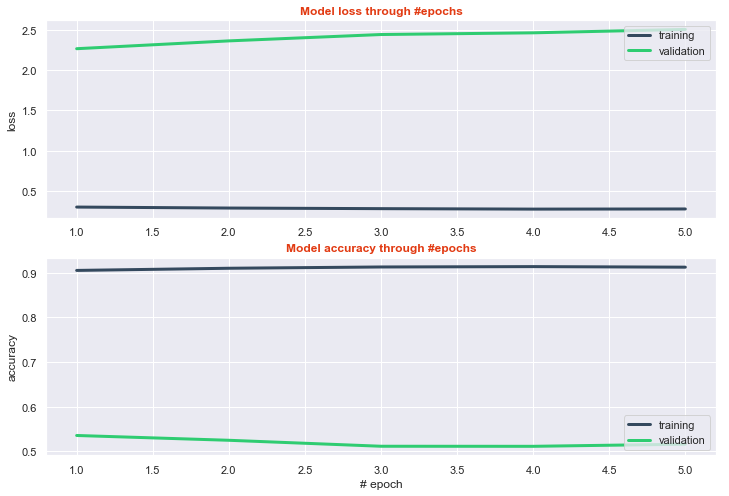

In [36]:
# plot loss and accuracy
plot_model_performance(history.history["loss"], history.history["acc"], history.history["val_loss"], history.history["val_acc"])

## 2. Biderectional LSTM

In [37]:
train_gen = generate_batch(sents_word, s_word2index, sents_pos,
                           t_word2index, BATCH_SIZE, MAX_SEQLEN)
test_gen = generate_batch(test_sents_word, s_word2index, test_sents_pos,
                          t_word2index, BATCH_SIZE, MAX_SEQLEN)

In [38]:
sents_word, word_frequencies, sents_pos, pos_frequencies = parsed_sentences(train_conll_fname)
test_sents_word, test_word_frequencies, test_sents_pos, test_pos_frequencies = parsed_sentences(test_conll_fname)

In [39]:
hist_acc, hist_val_acc, hist_loss, hist_val_loss = [], [], [], []

In [40]:
for i in range(NUM_ITERATIONS):    
    history = Bidirectional_POS_TAGGER.fit_generator(train_gen, 
                                  steps_per_epoch=num_train_samples, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=test_gen, 
                                  validation_steps=num_test_samples)
    # save off history data
    hist_acc.extend(history.history["acc"])
    hist_val_acc.extend(history.history["val_acc"])
    hist_loss.extend(history.history["loss"])
    hist_val_loss.extend(history.history["val_loss"])
    
    # Проиллюстрируем некоторые примеры разметки
    
    Xtest, Ytest = next(test_gen)
    Ytest_ = Bidirectional_POS_TAGGER.predict(Xtest)
    ytest = np.argmax(Ytest, axis=2)
    ytest_ = np.argmax(Ytest_, axis=2)
    
    print("=" * 80)
    print("Iteration # {:d}".format(i + 1))
    print("-" * 80)
    for i in range(min(5, Ytest.shape[0])):
        sent_ids = Xtest[i]
        sent_words = [s_index2word[x] for x in sent_ids.tolist()]
        pos_labels = [t_index2word[x] for x in ytest[i].tolist()]
        pos_preds = [t_index2word[x] for x in ytest_[i].tolist()]
        triples = [x for x in zip(sent_words, pos_labels, pos_preds)
            if x[0] != "PAD"]
        print("label:     " + " ".join([x[0] +"//"+x[1].upper() 
            for x in triples]))
        print("predicted: " + " ".join([x[0] +"//"+x[2].upper() 
            for x in triples]))
        print("-" * 80)

Epoch 1/5
85/85 [==============================] - 17s 200ms/step - loss: 0.3356 - acc: 0.8826 - val_loss: 1.5704 - val_acc: 0.5879
Epoch 2/5
85/85 [==============================] - 17s 198ms/step - loss: 0.3131 - acc: 0.8930 - val_loss: 1.6271 - val_acc: 0.5880
Epoch 3/5
85/85 [==============================] - 17s 200ms/step - loss: 0.3157 - acc: 0.8901 - val_loss: 1.6494 - val_acc: 0.5860
Epoch 4/5
85/85 [==============================] - 17s 201ms/step - loss: 0.2946 - acc: 0.8998 - val_loss: 1.7493 - val_acc: 0.5720
Epoch 5/5
85/85 [==============================] - 17s 201ms/step - loss: 0.2749 - acc: 0.9071 - val_loss: 1.7256 - val_acc: 0.5870
Iteration # 1
--------------------------------------------------------------------------------
label:     При//ADP цій//DET UNK//NOUN вести//VERB в//ADP кожній//DET хаті//NOUN нашу//DET UNK//NOUN .//PUNCT
predicted: При//PAD цій//DET UNK//DET вести//DET в//VERB кожній//VERB хаті//NOUN нашу//NUM UNK//NOUN .//PUNCT
-------------------------

85/85 [==============================] - 17s 202ms/step - loss: 0.1445 - acc: 0.9595 - val_loss: 1.9794 - val_acc: 0.5899
Epoch 2/5
85/85 [==============================] - 17s 198ms/step - loss: 0.1306 - acc: 0.9643 - val_loss: 2.0118 - val_acc: 0.5942
Epoch 3/5
85/85 [==============================] - 17s 198ms/step - loss: 0.1287 - acc: 0.9650 - val_loss: 2.1354 - val_acc: 0.5847
Epoch 4/5
85/85 [==============================] - 17s 200ms/step - loss: 0.1272 - acc: 0.9645 - val_loss: 2.0877 - val_acc: 0.5894
Epoch 5/5
85/85 [==============================] - 17s 199ms/step - loss: 0.1303 - acc: 0.9632 - val_loss: 2.0966 - val_acc: 0.5959
Iteration # 4
--------------------------------------------------------------------------------
label:     UNK//PROPN ,//PUNCT обласній//ADJ UNK//ADJ адміністрації//NOUN для//ADP надання//NOUN висновку//NOUN щодо//ADP UNK//NOUN цього//DET проекту//NOUN Конституції//NOUN та//CCONJ UNK//NOUN України//PROPN .//PUNCT
predicted: UNK//NOUN ,//PUNCT обласн

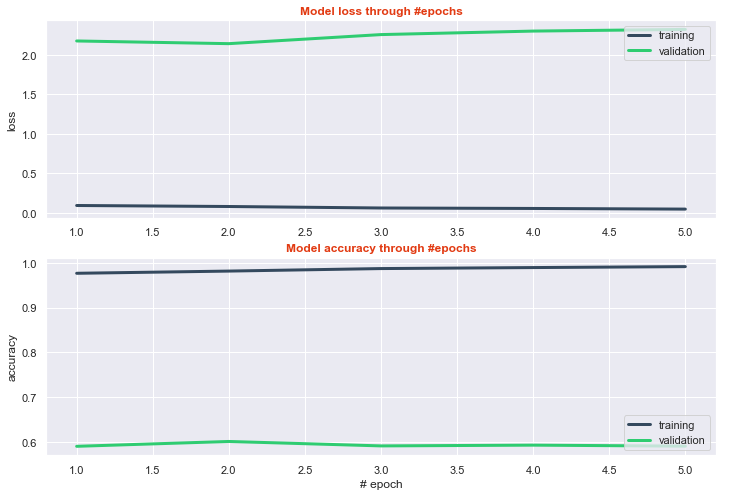

In [42]:
# plot loss and accuracy
plot_model_performance(history.history["loss"], history.history["acc"], history.history["val_loss"], history.history["val_acc"])

## 3. GRU

In [43]:
train_gen = generate_batch(sents_word, s_word2index, sents_pos,
                           t_word2index, BATCH_SIZE, MAX_SEQLEN)
test_gen = generate_batch(test_sents_word, s_word2index, test_sents_pos,
                          t_word2index, BATCH_SIZE, MAX_SEQLEN)

In [44]:
sents_word, word_frequencies, sents_pos, pos_frequencies = parsed_sentences(train_conll_fname)
test_sents_word, test_word_frequencies, test_sents_pos, test_pos_frequencies = parsed_sentences(test_conll_fname)

In [45]:
hist_acc, hist_val_acc, hist_loss, hist_val_loss = [], [], [], []

In [46]:
GRU_POS_TAGGER = build_pos_tagger_GRU()

In [47]:
for i in range(NUM_ITERATIONS):    
    history = GRU_POS_TAGGER.fit_generator(train_gen, 
                                  steps_per_epoch=num_train_samples, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=test_gen, 
                                  validation_steps=num_test_samples)
    # save off history data
    hist_acc.extend(history.history["acc"])
    hist_val_acc.extend(history.history["val_acc"])
    hist_loss.extend(history.history["loss"])
    hist_val_loss.extend(history.history["val_loss"])
    
    # Проиллюстрируем некоторые примеры разметки
    
    Xtest, Ytest = next(test_gen)
    Ytest_ = GRU_POS_TAGGER.predict(Xtest)
    ytest = np.argmax(Ytest, axis=2)
    ytest_ = np.argmax(Ytest_, axis=2)
    
    print("=" * 80)
    print("Iteration # {:d}".format(i + 1))
    print("-" * 80)
    for i in range(min(5, Ytest.shape[0])):
        sent_ids = Xtest[i]
        sent_words = [s_index2word[x] for x in sent_ids.tolist()]
        pos_labels = [t_index2word[x] for x in ytest[i].tolist()]
        pos_preds = [t_index2word[x] for x in ytest_[i].tolist()]
        triples = [x for x in zip(sent_words, pos_labels, pos_preds)
            if x[0] != "PAD"]
        print("label:     " + " ".join([x[0] +"//"+x[1].upper() 
            for x in triples]))
        print("predicted: " + " ".join([x[0] +"//"+x[2].upper() 
            for x in triples]))
        print("-" * 80)

Epoch 1/5
85/85 [==============================] - 18s 213ms/step - loss: 2.0800 - acc: 0.3630 - val_loss: 1.7346 - val_acc: 0.4440
Epoch 2/5
85/85 [==============================] - 12s 146ms/step - loss: 1.7029 - acc: 0.4462 - val_loss: 1.6997 - val_acc: 0.4584
Epoch 3/5
85/85 [==============================] - 12s 139ms/step - loss: 1.6307 - acc: 0.4631 - val_loss: 1.6319 - val_acc: 0.4778
Epoch 4/5
85/85 [==============================] - 13s 148ms/step - loss: 1.5607 - acc: 0.4832 - val_loss: 1.6007 - val_acc: 0.4862
Epoch 5/5
85/85 [==============================] - 13s 152ms/step - loss: 1.4933 - acc: 0.5019 - val_loss: 1.5398 - val_acc: 0.4897
Iteration # 1
--------------------------------------------------------------------------------
label:     UNK//NOUN та//CCONJ владі//NOUN Києва//PROPN за//ADP UNK//ADJ і//CCONJ UNK//ADJ UNK//NOUN у//ADP питаннях//NOUN підготовки//NOUN до//ADP UNK//ADJ UNK//ADJ UNK//NOUN .//PUNCT
predicted: UNK//NOUN та//NOUN владі//NOUN Києва//NOUN за//NO

Epoch 2/5
85/85 [==============================] - 13s 151ms/step - loss: 1.1478 - acc: 0.5903 - val_loss: 1.4435 - val_acc: 0.5366
Epoch 3/5
85/85 [==============================] - 12s 140ms/step - loss: 1.1057 - acc: 0.6047 - val_loss: 1.4624 - val_acc: 0.5281
Epoch 4/5
85/85 [==============================] - 13s 155ms/step - loss: 1.0827 - acc: 0.6123 - val_loss: 1.4749 - val_acc: 0.5271
Epoch 5/5
85/85 [==============================] - 13s 154ms/step - loss: 1.0520 - acc: 0.6216 - val_loss: 1.4990 - val_acc: 0.5238
Iteration # 4
--------------------------------------------------------------------------------
label:     UNK//ADJ ,//PUNCT туди//ADV буде//AUX їхати//VERB більше//ADV UNK//NOUN і//CCONJ вони//PRON UNK//VERB за//ADP UNK//ADJ UNK//NOUN до//ADP нашого//DET магазину//NOUN .//PUNCT
predicted: UNK//VERB ,//VERB туди//VERB буде//VERB їхати//VERB більше//VERB UNK//NOUN і//NOUN вони//NOUN UNK//NOUN за//VERB UNK//ADV UNK//VERB до//ADP нашого//ADP магазину//NOUN .//PUNCT
------

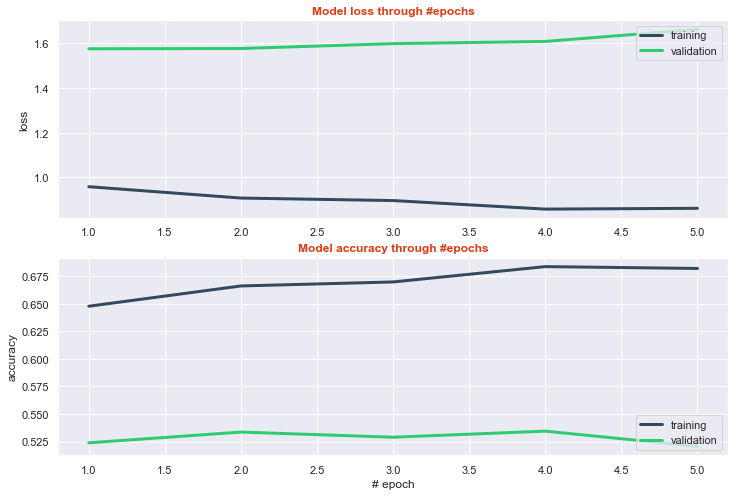

In [48]:
# plot loss and accuracy
plot_model_performance(history.history["loss"], history.history["acc"], history.history["val_loss"], history.history["val_acc"])

## 4. SimpleRNN

In [49]:
train_gen = generate_batch(sents_word, s_word2index, sents_pos,
                           t_word2index, BATCH_SIZE, MAX_SEQLEN)
test_gen = generate_batch(test_sents_word, s_word2index, test_sents_pos,
                          t_word2index, BATCH_SIZE, MAX_SEQLEN)

In [50]:
sents_word, word_frequencies, sents_pos, pos_frequencies = parsed_sentences(train_conll_fname)
test_sents_word, test_word_frequencies, test_sents_pos, test_pos_frequencies = parsed_sentences(test_conll_fname)

In [51]:
hist_acc, hist_val_acc, hist_loss, hist_val_loss = [], [], [], []

In [52]:
for i in range(NUM_ITERATIONS):    
    history = SimpleRNN_POS_TAGGER.fit_generator(train_gen, 
                                  steps_per_epoch=num_train_samples, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=test_gen, 
                                  validation_steps=num_test_samples)
    # save off history data
    hist_acc.extend(history.history["acc"])
    hist_val_acc.extend(history.history["val_acc"])
    hist_loss.extend(history.history["loss"])
    hist_val_loss.extend(history.history["val_loss"])
    
    # Проиллюстрируем некоторые примеры разметки
    
    Xtest, Ytest = next(test_gen)
    Ytest_ = SimpleRNN_POS_TAGGER.predict(Xtest)
    ytest = np.argmax(Ytest, axis=2)
    ytest_ = np.argmax(Ytest_, axis=2)
    
    print("=" * 80)
    print("Iteration # {:d}".format(i + 1))
    print("-" * 80)
    for i in range(min(5, Ytest.shape[0])):
        sent_ids = Xtest[i]
        sent_words = [s_index2word[x] for x in sent_ids.tolist()]
        pos_labels = [t_index2word[x] for x in ytest[i].tolist()]
        pos_preds = [t_index2word[x] for x in ytest_[i].tolist()]
        triples = [x for x in zip(sent_words, pos_labels, pos_preds)
            if x[0] != "PAD"]
        print("label:     " + " ".join([x[0] +"//"+x[1].upper() 
            for x in triples]))
        print("predicted: " + " ".join([x[0] +"//"+x[2].upper() 
            for x in triples]))
        print("-" * 80)

Epoch 1/5
85/85 [==============================] - 13s 158ms/step - loss: 1.8273 - acc: 0.4220 - val_loss: 1.6959 - val_acc: 0.4593
Epoch 2/5
85/85 [==============================] - 9s 110ms/step - loss: 1.6411 - acc: 0.4667 - val_loss: 1.6175 - val_acc: 0.4747
Epoch 3/5
85/85 [==============================] - 9s 102ms/step - loss: 1.5320 - acc: 0.4858 - val_loss: 1.5893 - val_acc: 0.4857
Epoch 4/5
85/85 [==============================] - 8s 91ms/step - loss: 1.4420 - acc: 0.5026 - val_loss: 1.5804 - val_acc: 0.4880
Epoch 5/5
85/85 [==============================] - 7s 84ms/step - loss: 1.3580 - acc: 0.5215 - val_loss: 1.5568 - val_acc: 0.4934
Iteration # 1
--------------------------------------------------------------------------------
label:     UNK//INTJ ))//SYM
predicted: UNK//PAD ))//PAD
--------------------------------------------------------------------------------
label:     Сьогодні//ADV ,//PUNCT на//ADP відміну//NOUN від//ADP минулої//ADJ доби//NOUN ,//PUNCT найбільша//ADJ 

85/85 [==============================] - 7s 83ms/step - loss: 0.7863 - acc: 0.7066 - val_loss: 1.7111 - val_acc: 0.5069
Epoch 2/5
85/85 [==============================] - 7s 83ms/step - loss: 0.7563 - acc: 0.7199 - val_loss: 1.7373 - val_acc: 0.5004
Epoch 3/5
85/85 [==============================] - 7s 84ms/step - loss: 0.7207 - acc: 0.7330 - val_loss: 1.7521 - val_acc: 0.5074
Epoch 4/5
85/85 [==============================] - 7s 82ms/step - loss: 0.6784 - acc: 0.7505 - val_loss: 1.8463 - val_acc: 0.4963
Epoch 5/5
85/85 [==============================] - 7s 82ms/step - loss: 0.6618 - acc: 0.7572 - val_loss: 1.8707 - val_acc: 0.4915
Iteration # 4
--------------------------------------------------------------------------------
label:     UNK//NOUN UNK//X не//PART UNK//VERB на//ADP UNK//ADJ UNK//NOUN UNK//X в//ADP UNK//X .//PUNCT
predicted: UNK//ADP UNK//VERB не//VERB UNK//VERB на//ADP UNK//NOUN UNK//NOUN UNK//ADP в//ADP UNK//NOUN .//PUNCT
-------------------------------------------------

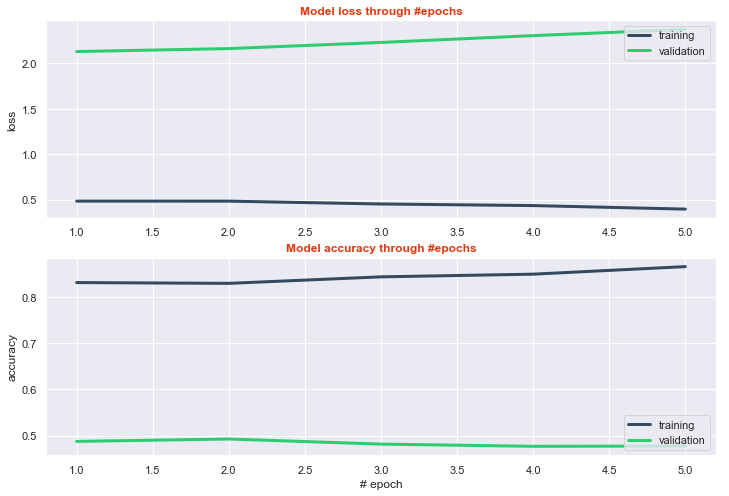

In [53]:
# plot loss and accuracy
plot_model_performance(history.history["loss"], history.history["acc"], history.history["val_loss"], history.history["val_acc"])

## Результаты

Наилучший показатель accuracy показывает Bidirectional LSTM - 0.59, что ожидаемо, т.к. данная архитектура лучше всего использует контекст данных для предсказания.

Наихудший показатель accuracy показывает SimpleRNN - 0.47,т.к. нет механизма для запоминания результатов, и она теряет градиенты.


### Проверка размера Embedding

Изменений в качестве предсказаний не было замечено. Скорее всего проблема заключается в малом размере данных.